In [483]:
import numpy as np
import matplotlib.pyplot as plt
print("importing modules done")

importing modules done


In [484]:
def fft_array(array, chunk_n):
    if len(array)%chunk_n != 0:
        exit -1
    spliter = len(array)/chunk_n
    splited_array = np.array_split(array,spliter)
    aux = []
    for piece in splited_array:
        aux.append(np.fft.fft(piece) )
    return aux

def total_power(array):
    return np.power(np.abs(array),2)

def total_power_list(array_list):
    aux = []
    for array in array_list:
        aux.append(total_power(array/len(array)))
    return aux

def accumulate(array_list):
    aux = np.zeros(len(array_list[0]))
    for array in array_list:
        aux += array
    return aux

def channel_accumulation(array, goal):
    # Split the array into the desired number of windows
    windows = np.array_split(array, goal)
    # Pre-allocate the result array with the correct size
    result = np.zeros(len(windows))
    # Accumulate the sum of each window into the result array
    for i in range(len(windows)):
        result[i] = np.sum(windows[i])
    return result

def channel_accumulation2(array, goal):
    reshaped_array = array.reshape(-1, goal)
    summed_array_y = reshaped_array.sum(axis=1)
    return summed_array_y

def channel_accumulation_list(array_list,goal):
    aux = []
    for array in array_list:
        aux.append(channel_accumulation(array,goal))
    return aux

def correlation(lista1, lista2):
    aux = []
    for i in range(len(lista1)):
        lista2_conjugated = np.conjugate(lista2[i])
        correlation_result = np.multiply(
            lista1[i],
            lista2_conjugated
            )
        aux.append(correlation_result)
    return aux

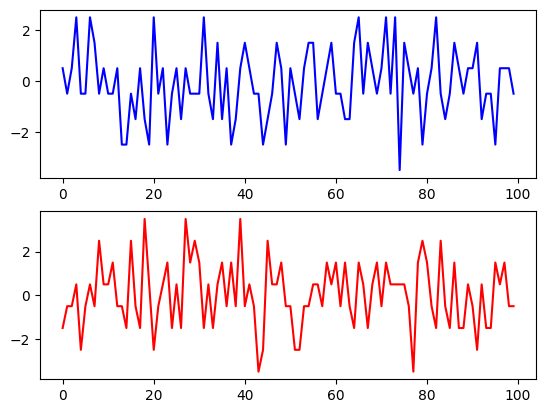

In [485]:
""" Same config utilized by Manabu """
delay = 1024               # zero: auto data,   positive integer: cross data
seed = 42               # Fixed seed for the random number generator
quant_levels = np.array([-7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2])  # Quantization levels
half_width = 3
np.random.seed(seed)
time_series_lenght = 2**20

""" Same timeseries utilized by Manabu """
noise = np.random.normal(loc=0, scale=half_width / 2, size=time_series_lenght)
indices = np.digitize(noise, bins=(quant_levels[:-1] + quant_levels[1:]) / 2)
quantized_noise= quant_levels[indices]


""" Rolling the array """
noise_array = quantized_noise
noise_array_rolled = np.roll(noise_array,delay)

""" Take a look into the first 100 values """
figs , axs = plt.subplots(2,1)
axs[0].plot(noise_array[0:100],'b')
axs[1].plot(noise_array_rolled[0:100],'r')
plt.show()

In [486]:
def experiment(goal_window_size, fft_window, source1, source2):
    
    
    fft_1_list = fft_array(source1,fft_window)
    fft_2_list = fft_array(source2,fft_window)

    correlated_array = correlation(fft_1_list,fft_2_list)
    correlated_power = total_power_list(correlated_array)
    reduced_power = channel_accumulation_list(correlated_power,goal_window_size)
    #accumulated_power = accumulate(correlated_power)
    reduced_data = accumulate(reduced_power)
    #reduced_data = channel_accumulation(accumulated_power,goal_window_size)

    return reduced_data

0.5174067926960876


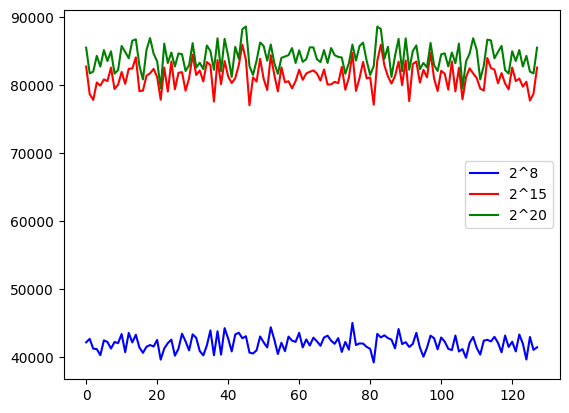

In [487]:
result1 = experiment(128,2**8,noise_array,noise_array_rolled)
result2 = experiment(128,2**15,noise_array,noise_array_rolled)
result3 = experiment(128,2**20,noise_array,noise_array_rolled)
total_power_ratio = np.sum(result1)/np.sum(result2)
print(total_power_ratio)
plt.figure()
plt.plot(result1,'b', label = '2^8')
plt.plot(result2,'r', label = '2^15')
plt.plot(result3,'g', label = '2^20')
plt.legend()
plt.show()

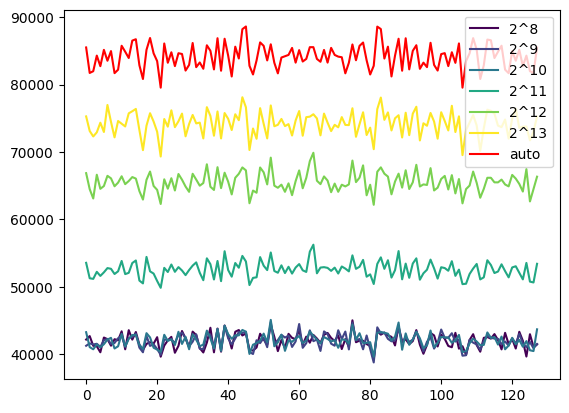

In [488]:
plt.figure()

colors = plt.cm.viridis(np.linspace(0, 1, 6))
for i in range(6):
    result = experiment(128,2**(i+8),noise_array,noise_array_rolled)
    plt.plot(result, label = "2^{}".format(8+i), color=colors[i])
result = experiment(128,2**20,noise_array,noise_array)
plt.plot(result,'r',label = 'auto')
plt.legend() 
plt.show()

(64,)
This is the half part ignoring the middle point: 31


C:\Users\isaac\AppData\Local\Temp\ipykernel_1680\3406819595.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  result[i] = np.sum(windows[i])


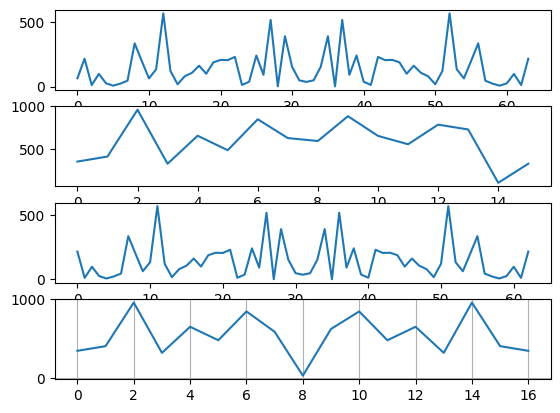

In [493]:
""" Same config utilized by Manabu """
delay = 0               # zero: auto data,   positive integer: cross data
seed = 42               # Fixed seed for the random number generator
quant_levels = np.array([-7/2, -5/2, -3/2, -1/2, 1/2, 3/2, 5/2, 7/2])  # Quantization levels
half_width = 3
np.random.seed(seed)
time_series_lenght = 2**7

""" Same timeseries utilized by Manabu """
noise = np.random.normal(loc=0, scale=half_width / 2, size=time_series_lenght)
indices = np.digitize(noise, bins=(quant_levels[:-1] + quant_levels[1:]) / 2)
quantized_noise= quant_levels[indices]


""" Rolling the array """
noise_array = quantized_noise
noise_array_rolled = np.roll(noise_array,delay)

def power(array):
    return np.power(np.abs(array),2)

fft_1 = np.fft.fft(noise_array[time_series_lenght//2:])
fft_2 = np.fft.fft(noise_array_rolled[time_series_lenght//2:])
fft_2_conj = np.conjugate(fft_2)

fig, axs = plt.subplots(4,1)
correlation1 = np.multiply(fft_1,fft_2)
correlation2 = np.multiply(fft_1,fft_2_conj)
axs[0].plot(correlation2, label = 'correlation+DC')
#axs[0].plot(channel_accumulation(correlation1,32))
print(correlation2.shape)
axs[1].plot(channel_accumulation((correlation2[1:]),16), label='channel accumulation correlation+DC')
axs[2].plot(correlation2[1:], label = 'Correlation')
correlation_no_dc = correlation2[1:]
first_half= channel_accumulation((correlation_no_dc[:len(correlation_no_dc)//2]),8)
second_half= channel_accumulation((correlation_no_dc[len(correlation_no_dc)//2:]),8)
print("This is the half part ignoring the middle point: {}".format(len(correlation_no_dc)//2))
final = np.append(first_half,correlation2[len(correlation_no_dc)//2+1])
final = np.append(final,second_half)
axs[3].plot(final, label = 'simetric channel accumulation, middle point added later')
plt.grid()
plt.show()

(128,)
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128.]


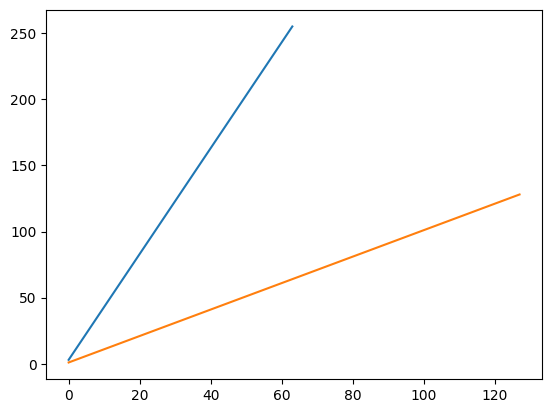

In [490]:
numbers = np.linspace(1,2**7,2**7)
print(numbers.shape)
print(numbers)
numbers_splitted = np.array_split(numbers,4)

plt.figure()
plt.plot(channel_accumulation(numbers,2**6))
plt.plot(numbers)